In [48]:
class Player:
    def __init__(self, name, position, three_pt, midrange, inside, defense, stamina, speed, iq, usage, rebounding,passing):
        self.name = name
        self.position = position
        self.three_pt = three_pt
        self.midrange = midrange
        self.inside = inside
        self.defense = defense
        self.stamina = stamina
        self.speed = speed
        self.iq = iq
        self.usage = usage
        self.confidence = 1.0
        self.rebounding = rebounding
        self.passing = passing
        
        self.points = 0
        self.shots_made = 0
        self.shots_attempted = 0
        self.assists = 0
        self.offRebounds = 0
        self.defRebounds = 0
        self.totalRebounds = 0
        self.threes_made = 0
        self.threes_attempted = 0

    def adjust_attributes(self, matchup_effect):
        self.three_pt += matchup_effect['three_pt']
        self.midrange += matchup_effect['midrange']
        self.inside += matchup_effect['inside']
        self.defense += matchup_effect['defense']

class Team:
    def __init__(self, name, players):
        self.name = name
        self.players = players
        self.strategy = 'balanced'

    def adjust_strategy(self, new_strategy):
        self.strategy = new_strategy


In [49]:
def calculate_matchup_effect(offensive_player, defensive_player):
    three_pt_effect = offensive_player.three_pt - defensive_player.defense * 0.11
    midrange_effect = offensive_player.midrange - defensive_player.defense * 0.11
    inside_effect = offensive_player.inside - defensive_player.defense * 0.11
    defense_effect = defensive_player.defense - (offensive_player.three_pt + offensive_player.midrange + offensive_player.inside) / 3
    return {'three_pt': three_pt_effect, 'midrange': midrange_effect, 'inside': inside_effect, 'defense': defense_effect}

def apply_matchup_effects(offensive_team, defensive_team):
    for player in offensive_team.players:
        for opponent in defensive_team.players:
            if player.position == opponent.position:
                effect = calculate_matchup_effect(player, opponent)
                player.adjust_attributes(effect)


In [50]:
import random
import matplotlib.pyplot as plt
import numpy as np

def generate_outcomes(players):
    outcomes = []
    for player in players:
        outcomes.extend([
            (f'{player.name} 3pt', player),
            (f'{player.name} Midrange', player),
            (f'{player.name} Inside', player)
        ])
    return outcomes

def get_success_rate(player, outcome):
    if '3pt' in outcome:
        return player.three_pt * 0.6
    elif 'Midrange' in outcome:
        return player.midrange * 0.7
    elif 'Inside' in outcome:
        return player.inside * 0.9
    return 0

def get_rebounding_synergy(team):
    totalRebounding = 0
    for player in team.players:
        totalRebounding += player.rebounding
    return totalRebounding

def choose_rebounder(team):
    weights = [player.rebounding for player in team.players]
    chosen_player = random.choices(team.players, weights=weights, k=1)[0]
    return chosen_player

def simulate_rebound(offensiveTeam, defensiveTeam, play_by_play):
    offRebounding = get_rebounding_synergy(offensiveTeam)
    defRebounding = get_rebounding_synergy(defensiveTeam)
    offReboundingProbability = (offRebounding*0.25)/ (offRebounding+defRebounding)
    if random.random() < offReboundingProbability:
        rebounder = choose_rebounder(offensiveTeam)
        rebounder.offRebounds += 1
        rebounder.totalRebounds += 1
        play_by_play.append(f"{rebounder.name} grabs the offensive rebound.")
        return offensiveTeam, defensiveTeam
        
    else:
        rebounder = choose_rebounder(defensiveTeam)
        rebounder.defRebounds += 1
        rebounder.totalRebounds += 1
        play_by_play.append(f"{rebounder.name} grabs the defensive rebound.")
        return defensiveTeam, offensiveTeam

def get_defensive_synergy(team):
    totalDef = 0
    for player in team.players:
        totalDef += player.defense
    return totalDef

def simulate_assist(player, defTeam):
    teamDef = get_defensive_synergy(defTeam)
    assistProb = (player.passing)/(player.passing + (teamDef/5))
    if random.random() < assistProb:
        player.assists += 1
        return True
    
    return False
def simulate_possession(offensive_team, defensive_team, play_by_play):
    # Generate outcomes dynamically based on the players in the team
    outcomes = generate_outcomes(offensive_team.players)
    
    # Select key decision maker based on usage probability
    decision_maker = random.choices(offensive_team.players, weights=[p.usage for p in offensive_team.players], k=1)[0]
    
    
    # Adjust the weights based on the decision maker's IQ
    outcome_weights = []
    for outcome, player in outcomes:
        success_rate = get_success_rate(player, outcome)
        base_weight = 1  # Each outcome starts with an equal base weight
        if decision_maker.iq > 75:
            weight = base_weight * (1 + success_rate/100)  # Higher IQ favors more successful outcomes
            if (success_rate <= 50):
                weight = base_weight * (success_rate/100)
        else:
            if (success_rate <= 50):
                weight = base_weight * (success_rate/100)
            else:
                weight = base_weight  # Lower IQ keeps the weight distribution more even
        outcome_weights.append(weight)
    
    selected_outcome, selected_player = random.choices(outcomes, weights=outcome_weights, k=1)[0]
    
    # Success check based on matchup and player attributes
    primary_defender = next(p for p in defensive_team.players if p.position == selected_player.position)
    success_probability = (get_success_rate(selected_player, selected_outcome) / 
                           (get_success_rate(selected_player, selected_outcome) + primary_defender.defense))
    

    selected_player.shots_attempted += 1
    if random.random() < success_probability:
        result = 'made'
        selected_player.shots_made += 1
        decision_maker.assists += 1
        if '3pt' in selected_outcome:
            selected_player.points += 3
            selected_player.threes_made += 1
            selected_player.threes_attempted += 1
        else:
            selected_player.points += 2
        possession = defensive_team, offensive_team
    else:
        result = 'missed'
        if '3pt' in selected_outcome:
            selected_player.threes_attempted += 1
    
    # Add to play-by-play
    if (decision_maker == selected_player or result == 'missed'):
        play_by_play.append(f"{selected_outcome} and {result}.")

    elif (result == 'made'):
        if (simulate_assist(decision_maker, defensive_team)):
            play_by_play.append(f"{selected_outcome} and {result} Ast. {decision_maker.name}")
        else:
            play_by_play.append(f"{selected_outcome} and {result}")
        possession = defensive_team, offensive_team
        
    if (result == 'missed'):
        possession = simulate_rebound(offensive_team, defensive_team, play_by_play)
    
    return selected_outcome, result, possession

def simulate_game(team1, team2, possessions):
    team1_score = 0
    team2_score = 0
    play_by_play = []

    outcome, result, possession = simulate_possession(team1, team2, play_by_play)
    
    for i in range(possessions-1):
        offensiveTeam = possession[0]
        defensiveTeam = possession[1]
        outcome, result, possession = simulate_possession(offensiveTeam, defensiveTeam, play_by_play)
        if result == 'made':
            if '3pt' in outcome:
                if (offensiveTeam == team1): team1_score += 3
                else: team2_score += 3
            elif 'Midrange' in outcome or 'Inside' in outcome:
                if (offensiveTeam == team1): team1_score += 2
                else: team2_score += 2
            play_by_play.append(f"{team1_score}-{team2_score}")
                
    return team1_score, team2_score, play_by_play

def visualize_outcome_weights(team):
    outcomes = generate_outcomes(team.players)
    decision_makers = [player for player in team.players]
    
    for decision_maker in decision_makers:
        outcome_weights = []
        outcome_labels = []
        for outcome, player in outcomes:
            success_rate = get_success_rate(player, outcome)
            base_weight = 1  # Each outcome starts with an equal base weight
            if decision_maker.iq > 75:
                weight = base_weight * (1 + success_rate/100)  # Higher IQ favors more successful outcomes
                if success_rate <= 50:
                    weight = base_weight * (success_rate/100)
            else:
                if success_rate <= 50:
                    weight = base_weight * (success_rate/100)
                else:
                    weight = base_weight  # Lower IQ keeps the weight distribution more even
            outcome_weights.append(weight)
            outcome_labels.append(outcome)
        
        # Plot the outcome weights for the current decision maker
        fig, ax = plt.subplots()
        y_pos = np.arange(len(outcome_labels))
        ax.barh(y_pos, outcome_weights, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(outcome_labels)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Weight')
        ax.set_title(f'Outcome Weights for {decision_maker.name}')
        plt.show()


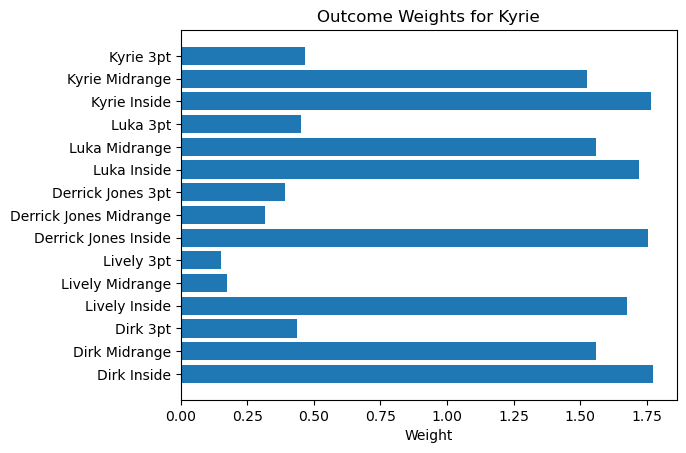

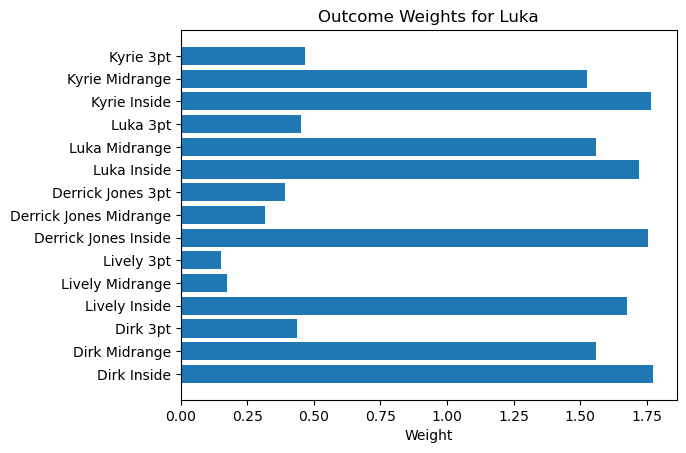

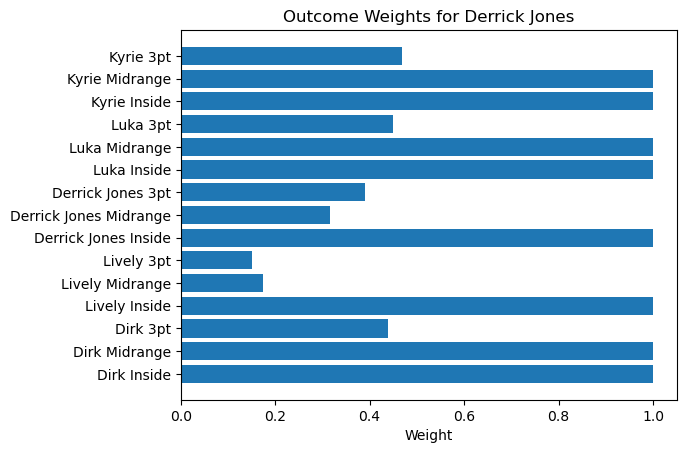

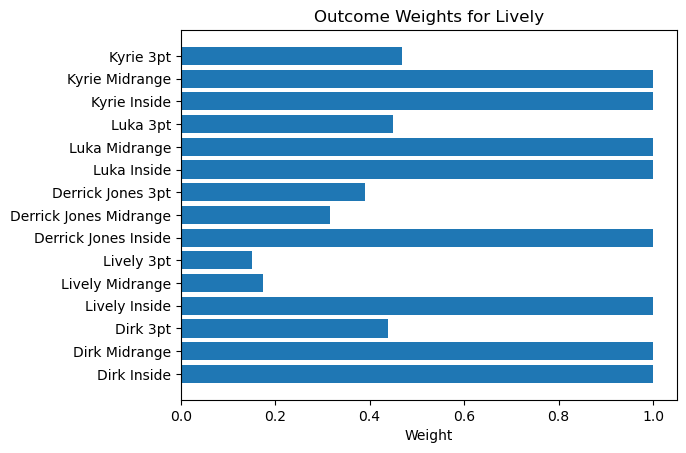

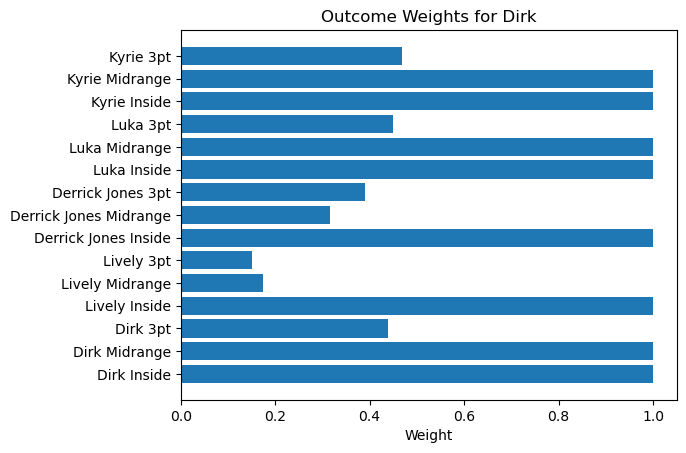

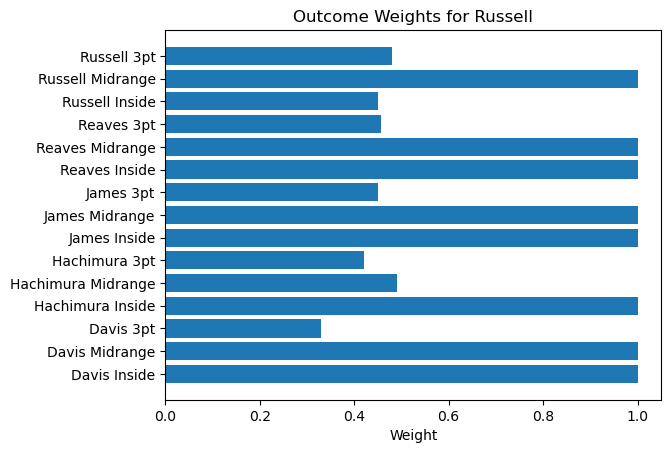

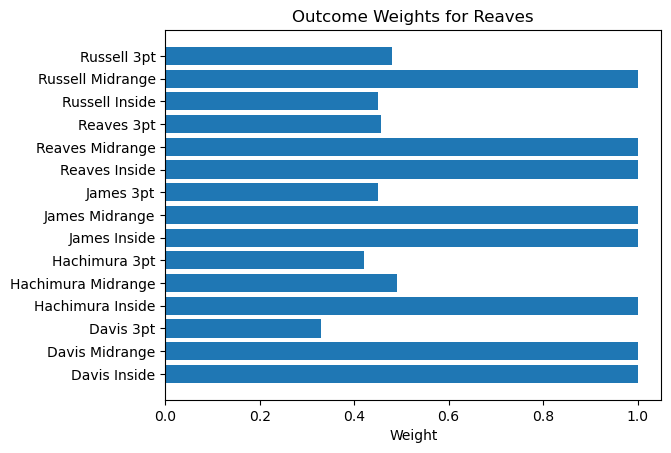

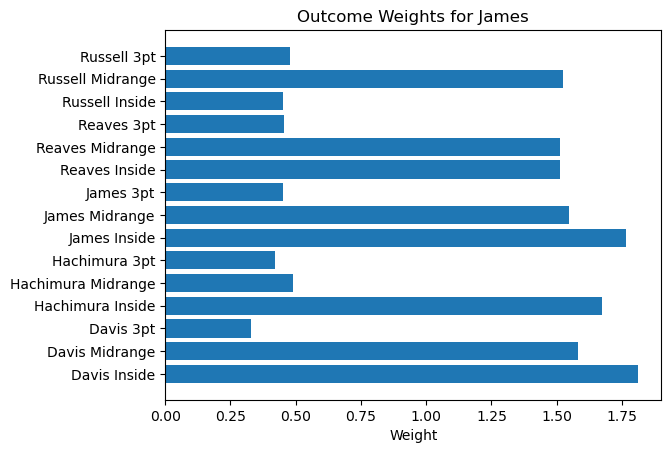

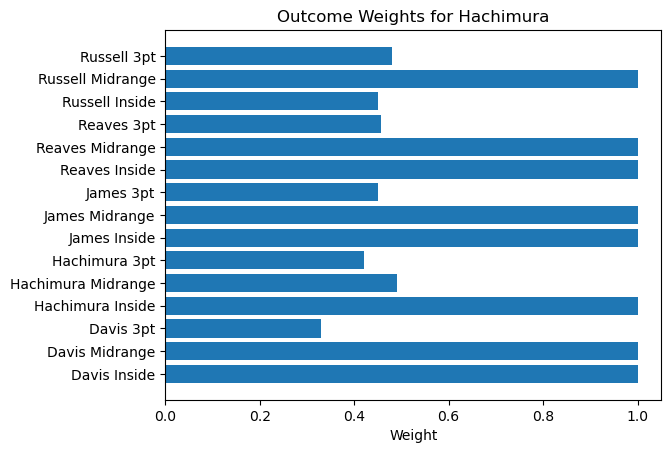

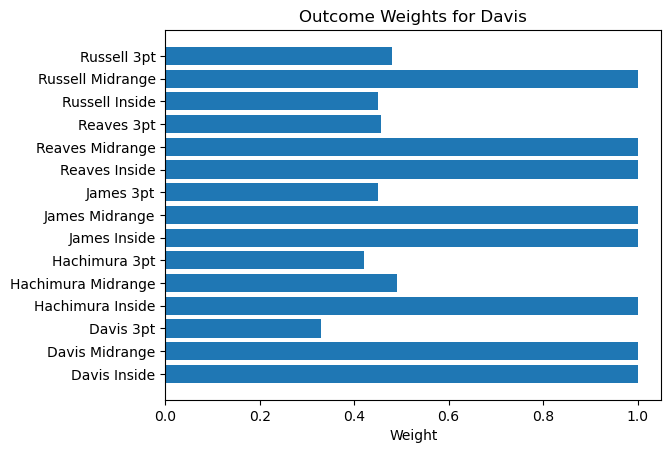

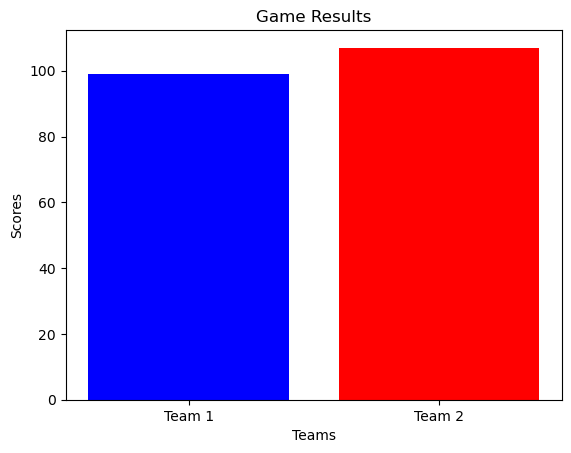

Luka Midrange and made
Russell Inside and made
0-2
Lively Inside and missed.
Russell grabs the defensive rebound.
James Inside and missed.
Lively grabs the defensive rebound.
Kyrie Midrange and made Ast. Dirk
2-2
Russell Midrange and made.
2-4
Derrick Jones Inside and missed.
Davis grabs the defensive rebound.
Hachimura 3pt and missed.
Lively grabs the defensive rebound.
Dirk Midrange and missed.
Russell grabs the defensive rebound.
Davis Inside and missed.
Derrick Jones grabs the defensive rebound.
Kyrie Inside and made
4-4
Davis Inside and made Ast. James
4-6
Lively Inside and missed.
Russell grabs the defensive rebound.
Hachimura Inside and missed.
Dirk grabs the defensive rebound.
Luka Midrange and made
6-6
Reaves Midrange and missed.
Reaves grabs the offensive rebound.
Davis Inside and missed.
Luka grabs the defensive rebound.
Kyrie Inside and made.
8-6
James Midrange and made Ast. Reaves
8-8
Lively Inside and missed.
Davis grabs the defensive rebound.
Reaves Midrange and made Ast

In [51]:
import matplotlib.pyplot as plt

def plot_game_results(team1_score, team2_score):
    labels = ['Team 1', 'Team 2']
    scores = [team1_score, team2_score]
    plt.bar(labels, scores, color=['blue', 'red'])
    plt.xlabel('Teams')
    plt.ylabel('Scores')
    plt.title('Game Results')
    plt.show()

def display_box_score(team):
    print(f"Box Score for {team.name}:")
    for player in team.players:
        print(f"{player.name} - Points: {player.points}, Assists: {player.assists}, "
              f"Shots Made: {player.shots_made}, Shots Attempted: {player.shots_attempted}, "
              f"DRebs: {player.defRebounds}, ORebs: {player.offRebounds}, " 
              f"Threes Made: {player.threes_made}, Threes Attempted: {player.threes_attempted}")

# Example usage
team1_players = [
    Player('Kyrie', 'PG', 78, 75, 85, 55, 85, 80, 80, 25, 30,70),
    Player('Luka', 'SG', 75, 80, 80, 60, 80, 40,90, 35, 65,85),
    Player('Derrick Jones', 'SF', 65, 45, 84, 80, 82,76,45, 10,50,50),
    Player('Lively', 'PF', 25, 25, 75, 75, 79, 50,30, 13, 70,35),
    Player('Dirk', 'C', 73, 80, 86, 72, 81, 45,65, 25, 60,55)
]

team2_players = [
    Player('Russell', 'PG', 80, 75, 50, 55, 85, 80, 65, 25, 30,70),
    Player('Reaves', 'SG', 76, 73, 57, 45, 80, 70,50, 15, 35,65),
    Player('James', 'SF', 75, 78, 85, 78, 82,76,90, 30,60,85),
    Player('Hachimura', 'PF', 70, 70, 75, 75, 79, 50,30, 13, 55,40),
    Player('Davis', 'C', 55, 83, 90, 90, 81, 45,55, 25, 80,45)
]

team1 = Team('Team 1', team1_players)
team2 = Team('Team 2', team2_players)

visualize_outcome_weights(team1)
visualize_outcome_weights(team2)

team1_score, team2_score, play_by_play = simulate_game(team1, team2, 200)
plot_game_results(team1_score, team2_score)

# Display play-by-play
for play in play_by_play:
    print(play)

# Display box scores
display_box_score(team1)
display_box_score(team2)


In [99]:
#pip install notebook
